**Autor:** Luis Aviles


El presente proyecto hace parte de la prueba técnica para optar a la posición de **Data Science en 1DOC3**.


El objetivo de este es que a partir del título de un producto crear un modelo que pueda predecir a que categoría pertenece este, las categorías son: **NOTEBOOKS, TABLETS, CELLPHONES y TELEPHONES**.

In [47]:
# Librerias requeridas para la manipulación de los datos.
import pandas as pd
import re

# Librerias requeridas para generar graficos y visualizaciones.
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Librerias necesarias para la generación y evaluación de modelos.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix

In [49]:
df = pd.read_csv('/content/train.csv')

ParserError: ignored

Al intentar leer el archivo CSV con los datos para iniciar con el análisis de los mismos, notamos que hay un error con respecto a la estructura de este.


Después de visualizar el archivo en una hoja de cálculo notamos que aunque los valores están separados por el símbolo "," en algunos casos (cuando el titulo del artículo contiene ",") los campos están dentro de comillas y en algunos casos existen ";" en cantidades variables al final de este, produciendo un error.


A continuación se procederá a realizar una función que permita crear un archivo en base al facilitado que no genere dicho error.

In [50]:
def correction_file(file_in, file_out):
  """Función para leer un archivo CSV con errores de estructura
     y crear un archivo obviando dichos errores.

  Parameters
  ----------
  file_in : String
      Nombre del archivo a leer.
  file_out : String
      Nombre del archivo a generar.

  Returns
  -------
  None
  """
  doc_in = open(file_in, mode='r')
  texto = []
  end_del = 0
  for x in doc_in:
    end_del = x[-6:].count(";")
    if end_del > 0:
      texto.append(x[:-(end_del + 1)])
    else:
      texto.append(x)
  doc_in.close()

  doc_out = open(file_out, mode='a')
  temp = ""
  for x in texto:
    if x.count(",") == 2:
      doc_out.write(x + "\n")
    else:
      temp = x.replace('"','')
      temp = temp.split(",")
      doc_out.write(temp[0] + ","  + " ".join(temp[1:-1]) + "," + temp[-1] + "\n")
  doc_out.close()

In [51]:
# Ejecucion de la función creada sobre el archivo train.csv
correction_file("/content/train.csv", "/content/train_fix.csv")

In [52]:
df = pd.read_csv("/content/train_fix.csv")

In [53]:
# Verificación de la cabezera del set de datos
df.head()

,label,title,is_validated_by_human
0,TELEPHONES,Teléfono Inalambrico Duo Motorola M700-2 + Han...,YES
1,NOTEBOOKS,Acer Aspire 7520 Notebook 17 Disco Ssd + Hdd ...,YES
2,TABLETS,Tablet Pc Box 7 Quad 1gb 8gb Doble Cam An...,YES
3,NOTEBOOKS,Notebook Hp X360 15.6 Intel I5 1tb 8gb Win10 T...,YES
4,NOTEBOOKS,Notebook Hp 240 G5 Freedos Core I3 Dvd Hdmi 4g...,YES


In [54]:
# Verificacion de la estructura del dataset
df.describe()

,label,title,is_validated_by_human
count,38705,38705,38705
unique,4,38705,2
top,TELEPHONES,iPad Para Repuestos,NO
freq,14037,1,32893


En la tabla se puede observar que el dataset no presenta datos nulos en ninguna de sus columnas, también se puede observar que:




*   No hay incongruencia con respecto a las columnas label y is_validated_by_human, las mismas muestran solo 4 y 2 valores respectivamente.
*   Las apariciones mayoritarias son "TELEPHONES" en el caso de label y "NO" en el caso de is_validated_by_human.
*   No existe ningún registro duplicado dado que en campo title todos sus valores son diferentes.

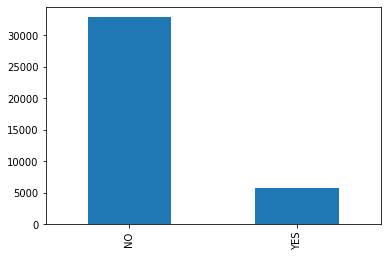

In [55]:
df['is_validated_by_human'].value_counts().plot(kind="bar")

En la graficá podemos observar que la mayoria de los registros fueron clasificados por una maquína. 

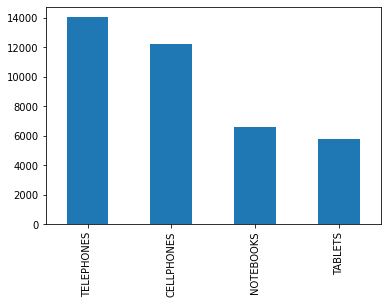

In [56]:
df['label'].value_counts().plot(kind="bar")

In [63]:
df['label'].value_counts()

TELEPHONES    14037
CELLPHONES    12253
NOTEBOOKS      6615
TABLETS        5800
Name: label, dtype: int64

A partir de la grafica y el conteo de los valores de la columna label se puede notar que el dataset precenta un desbalanceo siendo "TELEPHONES" y  "CELLPHONES" las clases mayoritarias en comparación a las clases "NOTEBOOK" y "TABLETS"

In [64]:
def preparacion_freq_word(data):
  """Función que toma una columna de datos y obtiene un conteo de las palabras
     que hacen parte de este obviando palabras con menos de 3 caracteres
     y devolviendo los un dataset y una lista con las palabras ordenadas.

  Parameters
  ----------
  data : DataFrame
      DataFrame al que se le va a realizar el analisis..

  Returns
  -------
  df_palabras
    Dataframe: Dataframe de palabras.
  texto_low
    List: Lista de palabras.
  """
  palabras = list(data)
  lista_palabras_sep = list(map(lambda x: x.split(" "), palabras))

  listado_aux = []
  for i in lista_palabras_sep:
    for j in i:
      listado_aux.append(j)

  listado_completo = " ".join(listado_aux)

  texto_low = listado_completo.lower()
  texto_low = texto_low.split(" ")

  contador_palabras={}

  for palabra in texto_low:
      if(len(palabra) > 3):
          if palabra in contador_palabras.keys():
              contador_palabras[palabra][0]+=1
          else:
              contador_palabras[palabra]=[1]
          
  # Convertimos el diccionario en un pandas DataFrame para ordernarlo:

  df_palabras = pd.DataFrame.from_dict(contador_palabras).transpose()
  df_palabras.columns=["freq"]
  df_palabras.sort_values(["freq"], ascending=False, inplace=True)
  return df_palabras, texto_low

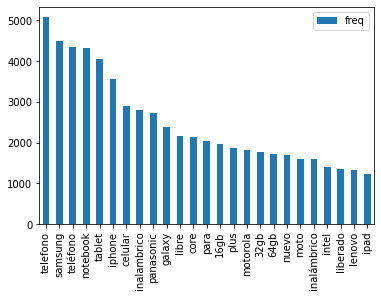

In [65]:
df_palabras, texto_low = preparacion_freq_word(df['title'])
df_palabras.head(25).plot(kind="bar")

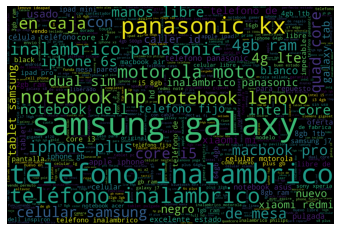

In [67]:
def nube_palabras(pack_palabras, max_words):
  """Función que a partir de una lista de palabras genera una nube de dicha lista.

  Parameters
  ----------
  pack_palabras : list
      Lista de palabras para generar el grafico.
  max_word : int
      Cantidad maxima de palabras a mostar en el grafico

  Returns
  -------
  None
  """
  texto_nube = " ".join(pack_palabras)
  wordcloud = WordCloud(height=1600, width=2400, background_color='black',max_words=max_words, min_font_size=5).generate(texto_nube)

  # Mostrar imagen generada:
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()
nube_palabras(texto_low, 500)

Basados en el grafico de barras y la nube de palabras podemos observar que el la palabra telefono es la que en mayor cantidad se encuentra en el dataset y aun más importante existen palabras las cuales se repiten con detalles a nivel ortográfico, otro detalle que se puede observar es que las palabras que más se encuentran en el corpus de texto son representativas a los label's del dataset.

In [68]:
# Tamaño del Corpus de texto analizado.
df_palabras.count()

freq    22960
dtype: int64

In [71]:
def normalizar_texto(cadena):
  """Función que toma una cadena de texto y modifica el sus vocales acentuadas
    por su equivalente no acentuado.

  Parameters
  ----------
  cadena : string
      Cadena de caracteres a modificar.

  Returns
  -------
  cadena
    string: Cadena modificada.
  """
  replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
  for a, b in replacements:
    cadena = cadena.replace(a, b)
  return cadena

In [72]:
def data_clean(frase):
  """Función que toma una cadena de texto y la modifica eliminando caracteres
     acentuados, colocándole en minúscula, eliminando caracteres especiales y
     eliminando sub-cadenas con una longitud menor a 4.

  Parameters
  ----------
  frase : string
      Cadena de caracteres a modificar.

  Returns
  -------
  frase
    string: Cadena modificada.
  """
  frase = normalizar_texto(frase)
  frase = frase.lower()
  frase = re.sub('[^A-Za-z0-9]+', ' ', frase)
  frase = frase.split(" ")
  frase = [x for x in frase if len(x)>3]
  frase = " ".join(frase)
  return frase

Dadas las inconsistencias encontradas en el dataset en el campo Title, se procede a la limpieza de esta y la creación de una versión limpia de esta columna.

In [73]:
df["title_clean"] = df['title'].apply(data_clean)

In [74]:
df_palabras_clean, texto_low_clean = preparacion_freq_word(df['title_clean'])

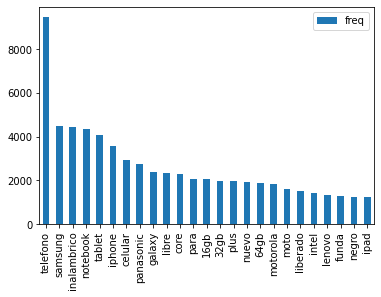

In [75]:
df_palabras_clean.head(25).plot(kind="bar")

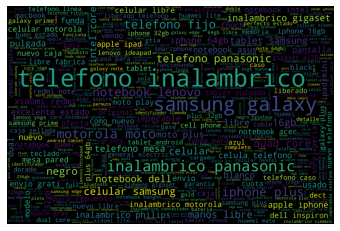

In [76]:
nube_palabras(texto_low_clean, 500)

In [77]:
df_palabras_clean.count()

freq    16059
dtype: int64

Después de realizar la limpieza los títulos y repetir el análisis previamente realizado, podemos notar que la nube de palabras se muestra **más uniforme** en comparación a la versión anterior y que el corpus se ha reducido de **22960** a **16059**

In [78]:
def target_convert(label):
  """Función que cambia los valores de la columna label por uno numérico.

  Parameters
  ----------
  label : string
      Cadena de caracteres a intercambiar.

  Returns
  -------
  resultado
    int: Valor numericó representativo de la emtrada.
  """
  resultado = {"TELEPHONES":0,
               "CELLPHONES":1,
               "NOTEBOOKS":2,
               "TABLETS":3}
  return resultado[label]
   

df['target'] = df['label'].apply(target_convert)

Para evitar algún problema de incompatibilidad se creó una nueva columna que realiza un cambio de los valores de la columna **"label"** a valores numéricos enteros, estos estarán en la columna **"target"**.

A continuación se realizará un primer primera prueba con respecto a la construcción del modelo.


Para la primera prueba se utilizara un árbol de decisión ya que estos tienden a funcionar bien para la creación de modelos basados en texto, previo a la creación del modelo se creara una bolsa de palabras con mil de estas de la columna "titulo_clean".


Basándonos en los resultados mostrados en esta prueba se decidirá si utilizar un modelo más robusto, si se requiere ajustar los hiperparametros del árbol, modificar el tamaño de la bolsa de palabras, entre otras cosas.

In [85]:
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(df['title_clean'])
X_vectorized = pd.DataFrame(X.toarray(), columns=matrix.get_feature_names())

In [86]:
data_test = pd.concat([X_vectorized, df['target']], axis=1)

In [87]:
X_prueba = data_test.drop(['target'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_prueba, data_test['target'], random_state=0)

In [88]:
clf = DecisionTreeClassifier(random_state = 0)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [89]:
target_names = ['TELEPHONES', 'CELLPHONES', 'NOTEBOOKS', 'TABLETS']
print(classification_report(Y_test, clf.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

  TELEPHONES       0.90      0.93      0.92      3553
  CELLPHONES       0.93      0.91      0.92      3064
   NOTEBOOKS       0.97      0.96      0.96      1654
     TABLETS       0.96      0.93      0.95      1406

    accuracy                           0.93      9677
   macro avg       0.94      0.93      0.94      9677
weighted avg       0.93      0.93      0.93      9677



<Figure size 7200x4320 with 0 Axes>

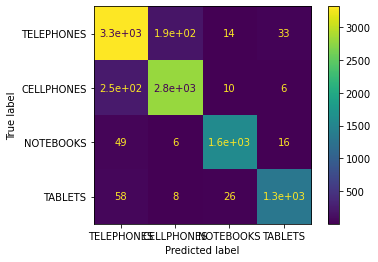

In [90]:
plt.figure(figsize=(100,60))
plot_confusion_matrix(clf, X_test, Y_test, display_labels=target_names)
plt.show()

Basándonos en los resultados obtenidos con las diferentes métricas (Precision, recall y F1-score) se puede decir que el no se requiere el uso de un modelo complejo (NN, GradientBosting, etc) para cumplir con los requerimientos solicitados.


En la matrix de confusión se puede observar que mayor cantidad de errores se presentan entre la clase "CELLPHONE" y "TELEPHONE"


A continuación se pasara a realizar a buscar los mejores parámetros para el modelo de árbol de decisión.

In [91]:
from sklearn.model_selection import GridSearchCV
arbol_decision = DecisionTreeClassifier()

In [96]:
param_dict = {"criterion": ["gini", "entropy"],
              "splitter": ["best", "random"],
              "max_depth": [3, 5, 10, 15, 20, 30, 50, 70],
              "min_samples_leaf": [1, 3, 5, 10]}

grib = GridSearchCV(arbol_decision,
                    param_grid=param_dict,
                    cv=10,
                    verbose=1,
                    n_jobs=-1)
grib.fit(X_train, Y_train)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed: 35.3min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                    

In [103]:
print(grib.best_estimator_.get_params())
print("Profundidad del arbol previamente entrenado: {}".format(clf.get_depth()))

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 70, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}
Profundidad del arbol previamente entrenado: 347


Después de la búsqueda por cuadrícula podemos notar que el parámetro de min_samples_leaf cambia su valor por defecto "2" por "3" junto con el parametro max_depth que tomo el valor más alto presentado en la lista de opciones 70, dando a entender que este valor está relacionado directamente con la "precisión" del modelo.

Dado que el valor de profundidad del modelo previamente entrenado es de 347, se mantendra dicho valor para futuras implementaciones.

In [105]:
import joblib
arbol_clf = DecisionTreeClassifier(max_depth=347, random_state=0)


In [106]:
arbol_clf.fit(X_prueba, data_test['target'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=347, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [107]:
filename = 'modelo.sav'
joblib.dump(arbol_clf, filename)

['modelo.sav']

Con el uso de la libreria joblib se almaceno el modelo entrenado con todos los datos suministrados en el archivo train.csv, el nombre del archivo es "modelo.sav".

A continuación tomaré dicho modelo y lo evaluaré con la data del archivo validation.csv

In [108]:
correction_file("/content/validation.csv", "/content/validation_fix.csv")
df_val = pd.read_csv("/content/validation_fix.csv")
df_val["title_clean"] = df_val['title'].apply(data_clean)
df_val['target'] = df_val['label'].apply(target_convert)

X_val = matrix.transform(df_val['title_clean'])
X_vectorized_val = pd.DataFrame(X_val.toarray(), columns=matrix.get_feature_names())

data_val = pd.concat([X_vectorized_val, df_val['target']], axis=1)
X_val = data_val.drop(['target'], axis=1)

In [109]:
modelo_cargado = joblib.load(filename)

print(classification_report(data_val['target'], modelo_cargado.predict(X_val), target_names=target_names))

              precision    recall  f1-score   support

  TELEPHONES       0.00      0.00      0.00         9
  CELLPHONES       0.77      0.23      0.36       141
   NOTEBOOKS       0.98      0.98      0.98       583
     TABLETS       0.98      0.94      0.96       512

    accuracy                           0.87      1245
   macro avg       0.68      0.54      0.57      1245
weighted avg       0.95      0.87      0.89      1245



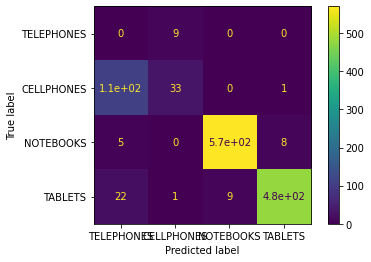

In [113]:
plot_confusion_matrix(modelo_cargado, X_val, data_val['target'], display_labels=target_names)
plt.show()

A partir de los resultados observados se puede observar que el modelo predice generalmente bien en el caso de "TABLETS" y  "NOTEBOOKS" pero presenta fallas en los casos de "CELLPHONES" y "TELEPHONES". Esta deficiencia pudiera ser solucionada aumentando el numero de palabras que forman el corpus o realizando undersampling de las clases "CELLPHONES" y "TELEPHONES" previo al entrenamiento del modelo.